In [1]:
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

In [2]:
import os
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np

## EDA

#### Problem Description 
 - Aim is to classify the correct vegetable from different images

#### Data Observation

In [3]:
# Reading images present for different classes

class_dirs = os.listdir("ninjacart_data/train/") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

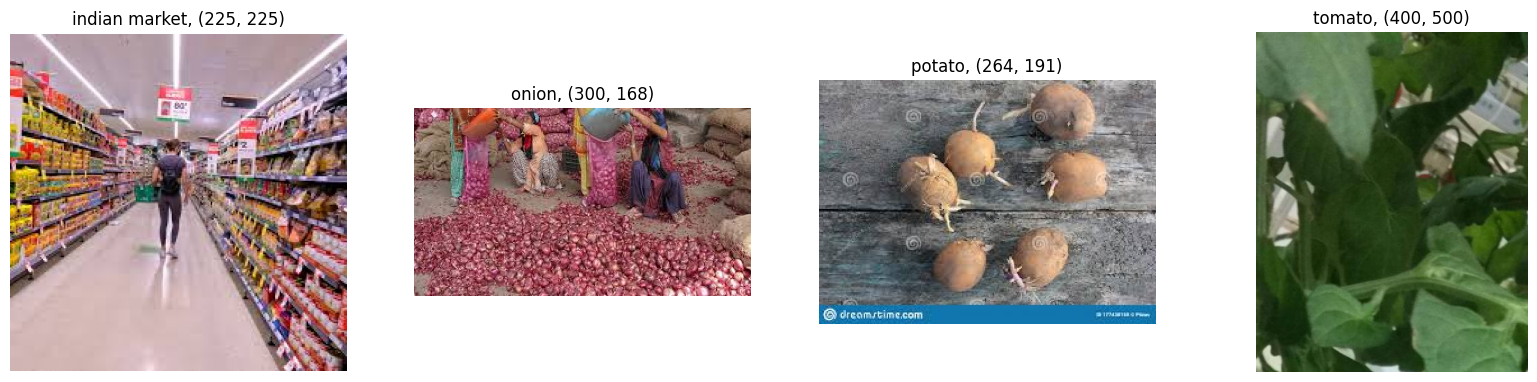

In [4]:
## Viz Random Sample from each class
plt.figure(figsize=(20, 15))

# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

#### Data Plots

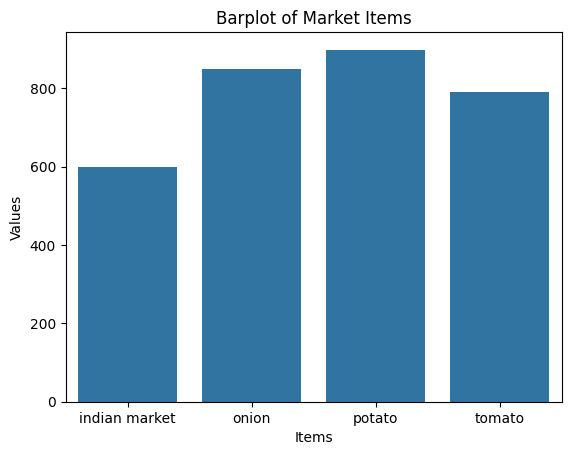

In [5]:
# Convert data to lists
items = list(count_dict.keys())
values = list(count_dict.values())

# Create a barplot
sns.barplot(x=items, y=values)

# Add labels and title
plt.xlabel('Items')
plt.ylabel('Values')
plt.title('Barplot of Market Items')

# Display the plot
plt.show()

* Since Class seems balanced no need of Data Augmentation

## Data Preprocessing, Rescaling, Resizing and Splitting

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/",shuffle =True, seed=123, validation_split=0.1, image_size=(224, 224),batch_size=32,  subset='training')
val_data = tf.keras.utils.image_dataset_from_directory("ninjacart_data/train/",shuffle =True, seed=123, validation_split=0.1, image_size=(224, 224),batch_size=32,  subset='validation')
test_data  = tf.keras.utils.image_dataset_from_directory("ninjacart_data/test/",shuffle =False, seed=123,image_size=(224, 224),batch_size=32)

Found 3135 files belonging to 4 classes.
Using 2822 files for training.
Found 3135 files belonging to 4 classes.
Using 313 files for validation.
Found 351 files belonging to 4 classes.


In [7]:
def preprocess_v2(train_data, val_data, test_data, target_height=224, target_width=224):

    # Data Processing Stage with resizing and rescaling operations #same as before for test,val
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Data Processing Stage with resizing and rotation operations
    data_augmentation = keras.Sequential(
        name="data_augmentation",
        layers=[
            # layers.RandomRotation
            layers.RandomRotation(factor=(-0.2, 0.3)),
            # layers.RandomBrightness(0.2), # Modify brightness by 0.2 factor
            layers.Rescaling(1.0/255), # Finally rescale
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    val_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    test_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = preprocess_v2(train_data, val_data, test_data)

In [22]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
# Get class names
class_names = train_data.class_names

# Count examples per class
class_counts = {}
for images, labels in train_data:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Print class counts
print("Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} examples")

Class Counts:
potato: 819 examples
onion: 765 examples
tomato: 702 examples
indian market: 536 examples


In [12]:
# Get class names
class_names = val_data.class_names

# Count examples per class
class_counts = {}
for images, labels in val_data:
    for label in labels.numpy():
        class_name = class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Print class counts
print("Class Counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} examples")

Class Counts:
potato: 79 examples
tomato: 87 examples
indian market: 63 examples
onion: 84 examples


## Model Building

### Base Model

In [13]:
def baseline(height=224, width=224):
    num_classes = 4
    # hidden_size = 48

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=20, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=48, activation='relu'),
            layers.Dropout(.4),
            layers.Dense(units=12, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model


model = baseline()
model.summary()

c:\Users\Varun.Tyagi\OneDrive - Brillio\Documents\workspace\pocs\Ninja\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 20)   │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 250880)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │    12,042,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,043,568 (45.94 MB)

 Trainable params: 12,043,528 (45.94 MB)

 Non-trainable params: 40 (160.00 B)

In [14]:
## Compile and Train

def compile_train_v1(model, train_ds, val_ds, ckpt_path="checkpoints/model_weights.weights.h5"):
    
    epochs = 10

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                          callbacks=[keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)]
                          )

    return model_fit

model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 61s 668ms/step - accuracy: 0.4584 - loss: 13.5141 - val_accuracy: 0.4185 - val_loss: 1.2452
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 691ms/step - accuracy: 0.5541 - loss: 1.2280 - val_accuracy: 0.4728 - val_loss: 1.0903
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 697ms/step - accuracy: 0.5494 - loss: 1.1577 - val_accuracy: 0.4984 - val_loss: 1.0053
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 62s 690ms/step - accuracy: 0.5907 - loss: 0.9814 - val_accuracy: 0.5367 - val_loss: 1.0490
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 665ms/step - accuracy: 0.5785 - loss: 1.0206 - val_accuracy: 0.6518 - val_loss: 0.8658
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 663ms/step - accuracy: 0.6145 - loss: 0.9540 - val_accuracy: 0.5112 - val_loss: 0.9733
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 644ms/step - accuracy: 0.5797 - loss: 1.0193 - val_accuracy: 0.6134 - val_loss: 2.1755
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 641ms/step - accuracy: 0.6000 - loss: 1.0038 - val_acc

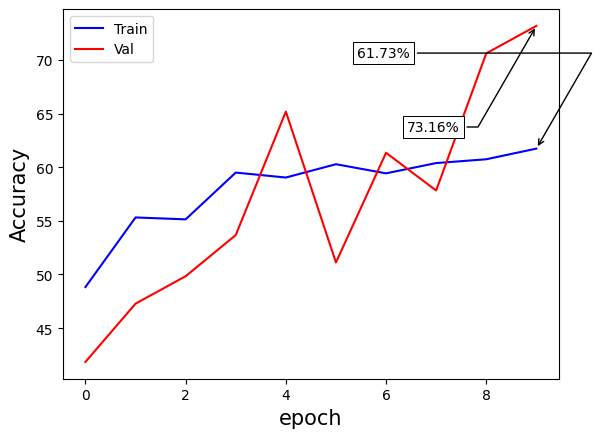

In [15]:
# Plot Train and Validation Accuracy

# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

Test Accuracy: 72.93%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


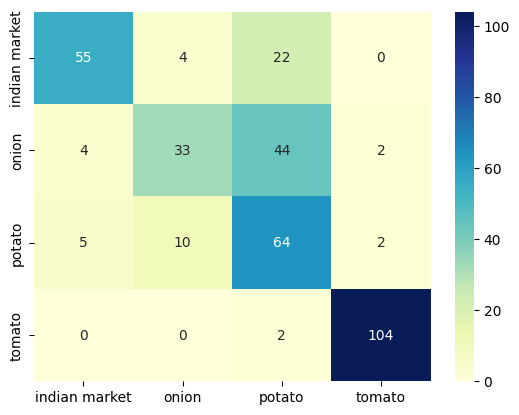

In [16]:
# Analyze results for Test Dataset

def print_accuracy_stats(model, ds, class_names):
    model.load_weights("checkpoints/model_weights.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    # true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    # test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    test_acc = metrics.accuracy_score(true_onehot, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("checkpoints/model_weights.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    # true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = metrics.confusion_matrix(true_onehot,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

### Transfer Learning : Mb1SSD

In [17]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    # Freezing the pretrained mobilenet layers except the last  layer, Known as fintuning the model
    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False

    #Output of base model
    x = mobilenet_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation = "relu")(x)
    output = layers.Dense(4, activation = 'softmax')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return pretrained_model

finetuned_mobilenet = build_model()

# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [18]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("checkpoints/mb1_model_weights.weights.h5", save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

In [19]:
finetuned_mobilenet = build_model()

finetuned_mobilenet.compile(
optimizer=tf.keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=["accuracy"],
)

history = finetuned_mobilenet.fit(
train_ds,
epochs = 10,
validation_data = val_ds,
callbacks=[checkpoint_cb]
)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 623ms/step - accuracy: 0.8094 - loss: 0.4739 - val_accuracy: 0.9393 - val_loss: 0.1594
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 52s 580ms/step - accuracy: 0.9473 - loss: 0.1508 - val_accuracy: 0.9649 - val_loss: 0.1190
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 51s 564ms/step - accuracy: 0.9621 - loss: 0.1226 - val_accuracy: 0.9265 - val_loss: 0.2454
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 51s 565ms/step - accuracy: 0.9680 - loss: 0.0889 - val_accuracy: 0.9585 - val_loss: 0.1264
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 50s 552ms/step - accuracy: 0.9665 - loss: 0.0896 - val_accuracy: 0.9681 - val_loss: 0.0937
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 52s 577ms/step - accuracy: 0.9727 - loss: 0.0613 - val_accuracy: 0.9744 - val_loss: 0.0680
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 631ms/step - accuracy: 0.9850 - loss: 0.0432 - val_accuracy: 0.9776 - val_loss: 0.0629
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 50s 558ms/step - accuracy: 0.9827 - loss: 0.0527 - val_accu

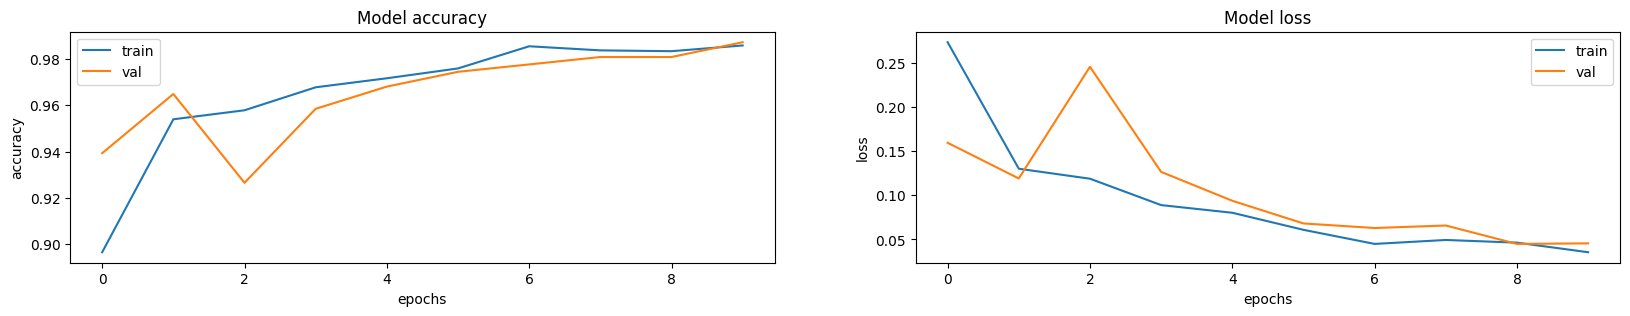

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 578ms/step

Test Accuracy: 91.74%

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step


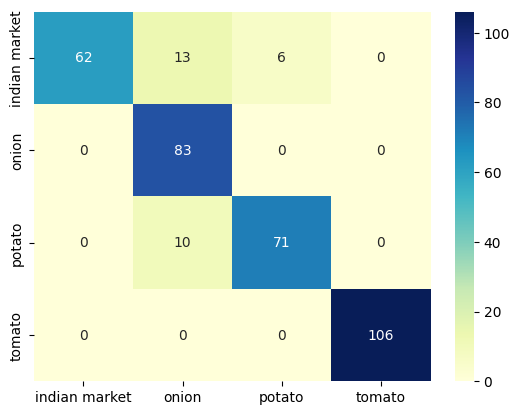

In [21]:
# Analyze results for Test Dataset

def print_accuracy_stats(model, ds, class_names):
    model.load_weights("checkpoints/mb1_model_weights.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    # true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    # test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    test_acc = metrics.accuracy_score(true_onehot, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("checkpoints/mb1_model_weights.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    # true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = metrics.confusion_matrix(true_onehot,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

print_accuracy_stats(finetuned_mobilenet, test_ds, class_names)
plot_confusion_matrix(finetuned_mobilenet, test_ds, class_names)

* Summary and Insights: As we can check using mb1ssd we are able to succesfully classify our Categories present in dataset.

1. Training Accuracy : ~98.74%
2. Validation Accuracy : ~98.72%
3. Testing Accuracy : ~91.74%